In [1]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt
import yfinance as yf

STOCK = 'GOOGL'
N_STEPS = 7

2024-02-19 10:36:15.111398: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [3]:
data = yf.download(
    STOCK, 
    start=date_3_years_back, 
    end=date_now, 
    interval='1d')
data = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
data['date'] = data.index

[*********************100%%**********************]  1 of 1 completed


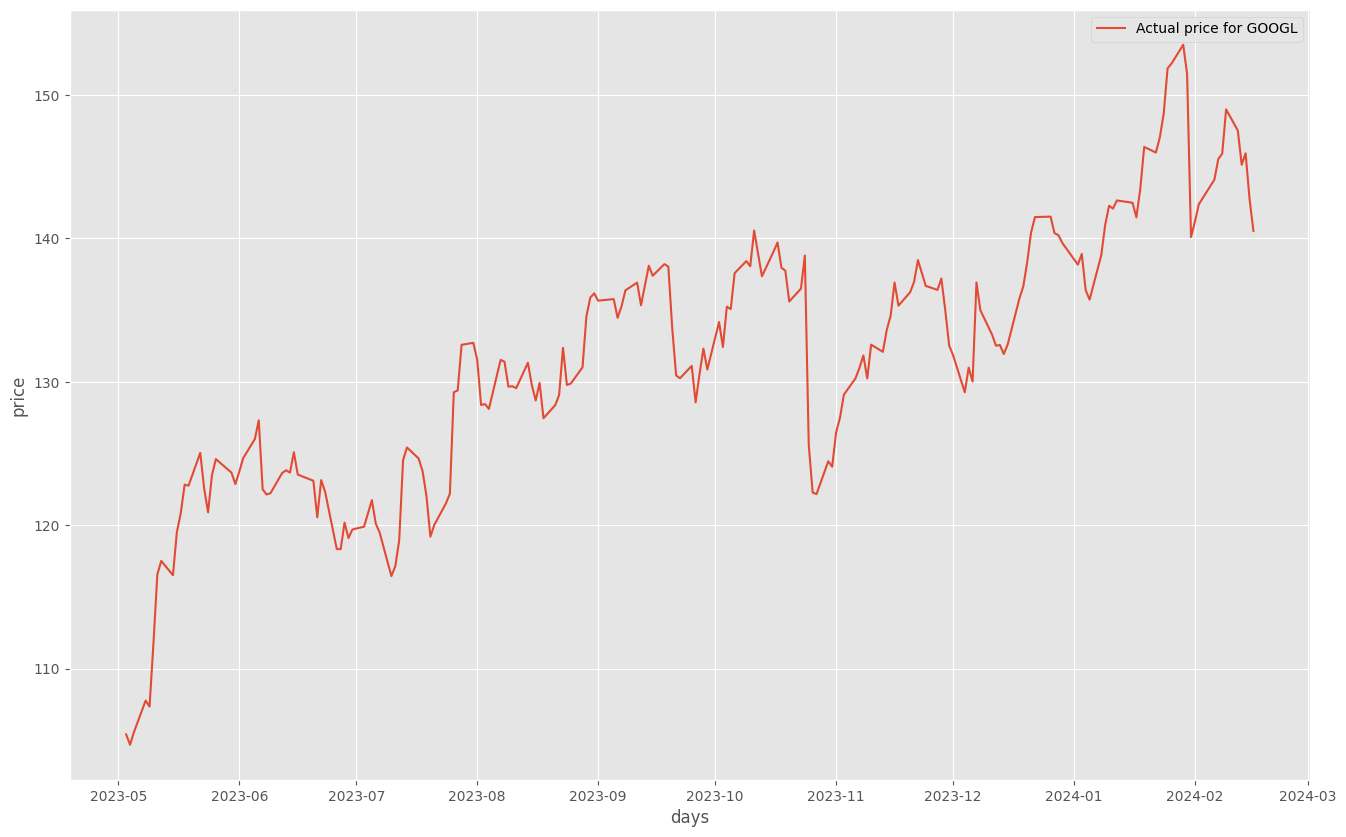

In [4]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(data['Close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [5]:
scaler = MinMaxScaler()
data['scaled'] = scaler.fit_transform(np.expand_dims(data['Close'].values, axis=1))

In [6]:
df = data.copy()
df['future'] = df['scaled'].shift(-1)
last_sequence = np.array(df[['scaled']].tail(1))
df.dropna(inplace=True)
sequence_data = []
sequences = deque(maxlen=N_STEPS)

In [7]:
for entry, target in zip(df[['Close'] + ['date']].values, df['future'].values):
    sequences.append(entry)
    if len(sequences) == N_STEPS:
        sequence_data.append([np.array(sequences), target])

In [8]:
last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
last_sequence = np.array(last_sequence).astype(np.float32)

In [9]:
X, Y = [], []
for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)
X = np.array(X)
Y = np.array(Y)
X = X[:, :, :1].astype(np.float32)

In [10]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(7, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [11]:
model = GetTrainedModel(X, Y)

Epoch 1/80
95/95 [==============================] - 5s 10ms/step - loss: 0.0636
Epoch 2/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0169
Epoch 3/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0127
Epoch 4/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0092
Epoch 5/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0090
Epoch 6/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0073
Epoch 7/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0068
Epoch 8/80
95/95 [==============================] - 1s 8ms/step - loss: 0.0066
Epoch 9/80
95/95 [==============================] - 1s 7ms/step - loss: 0.0057
Epoch 10/80
95/95 [==============================] - 1s 9ms/step - loss: 0.0059
Epoch 11/80
95/95 [==============================] - 1s 7ms/step - loss: 0.0053
Epoch 12/80
95/95 [==============================] - 1s 7ms/step - loss: 0.0054
Epoch 13/80
95/95 [============================

In [ ]:
last_sequence = last_sequence[-N_STEPS:]
last_sequence = np.expand_dims(last_sequence, axis=0)

In [ ]:
prediction = model.predict(last_sequence)